In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, make_scorer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.over_sampling import RandomOverSampler

In [50]:
def get_accuracy(model):

    print('-' * 80)
    print(f'\nMODEL: {model}\n')

    # Get sklearn accuracy score for given model; e.g., https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.score
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print(f'[*] Train Score: {str(train_score)}')
    print(f'[*] Test Score: {str(test_score)}')

    y_pred = model.predict(X_test)
    print('\n[*] Test Classification Report: \n', metrics.classification_report(y_test, y_pred))

    print('[*] Confusion Matrix on Test data')
    '''
    metrics.ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=list(range(2)), # length of unique values for label
    )
    '''
    cm = metrics.confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

    print(f'[*] Test Accuracy: {str(round(test_score, 5) * 100)}%')
    print('-' * 80 + '\n')

def select_optimal_model_parameters(default_model, gridsearch_model):
    """ Calculates accuracy for the default and Gridsearch nominated parameters and appends the model with the highest accuracy to the model evaluation list """
    # save for selection comparison against GridSearch nomination
    y_pred = default_model.predict(X_test)
    default_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    y_pred = gridsearch_model.predict(X_test)
    gridsearch_model_acc = metrics.accuracy_score(y_test, y_pred) *100

    # Compare the default and GridSearch paramaters for highest accuracy model to append to evaluation list
    if default_model_acc >= gridsearch_model_acc:
        print('Default parameter model selected')
        models.append(default_model)
    else:
        print('Gridsearch parameter model selected')
        models.append(gridsearch_model)

In [51]:
def plot_learning_curve(estimator, X, y, train_sizes, cv):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, train_sizes=train_sizes, cv=cv, scoring='accuracy', n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-Validation Score')
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend()
    plt.show()

def plot_validation_curve(clf, X_train, y_train, param_name, cv):
    # Define the hyperparameter range
    param_range = np.arange(1, 21)

    # Calculate training and validation scores over the specified hyperparameter range
    train_scores, test_scores = validation_curve(
        clf, X_train, y_train, param_name=param_name, param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=-1
    )

    # Plot the validation curve
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Validation Score')
    plt.title('Model Complexity Graph')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [52]:
models = []
# Load the dataset
file_path = "jobs_in_data.csv"
df = pd.read_csv(file_path)

# Convert 'salary_in_usd' to categories
df['salary_usd_group'] = pd.cut(
    df['salary_in_usd'],
    bins=[0, 50_000, 100_000, 200_000, 300_000, 400_000, 500_000],
    labels=['0-50K', '50k-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k']
)

# Encode categorical variables
le = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    df[column] = le.fit_transform(df[column])

# Separate features and target
X = df.drop(['salary', 'salary_in_usd','salary_usd_group'], axis=1)
y = df['salary_usd_group']

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

# Creating transformers for preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Use ColumnTransformer to apply transformers to specific feature columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ],
    remainder='passthrough'
)

# # Use RandomOverSampler to oversample minority classes
# oversampler = RandomOverSampler(random_state=42)
# X, y = oversampler.fit_resample(X, y)

10 6


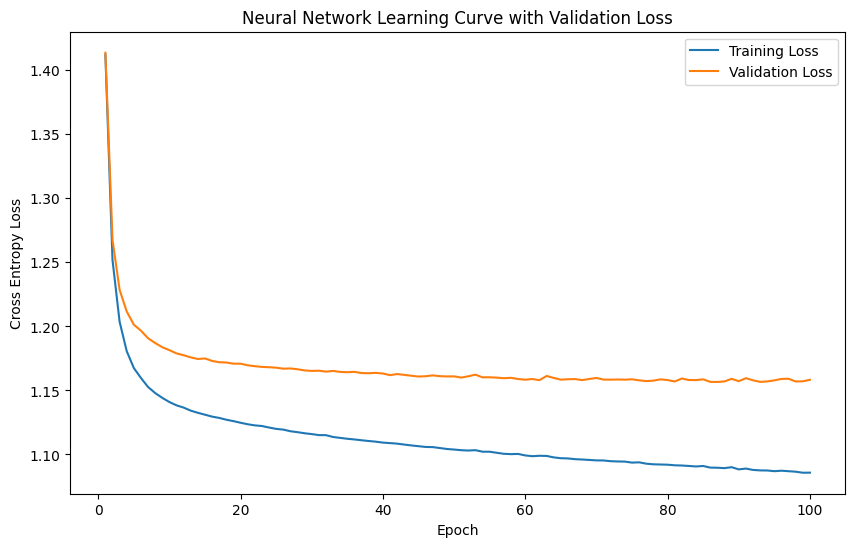

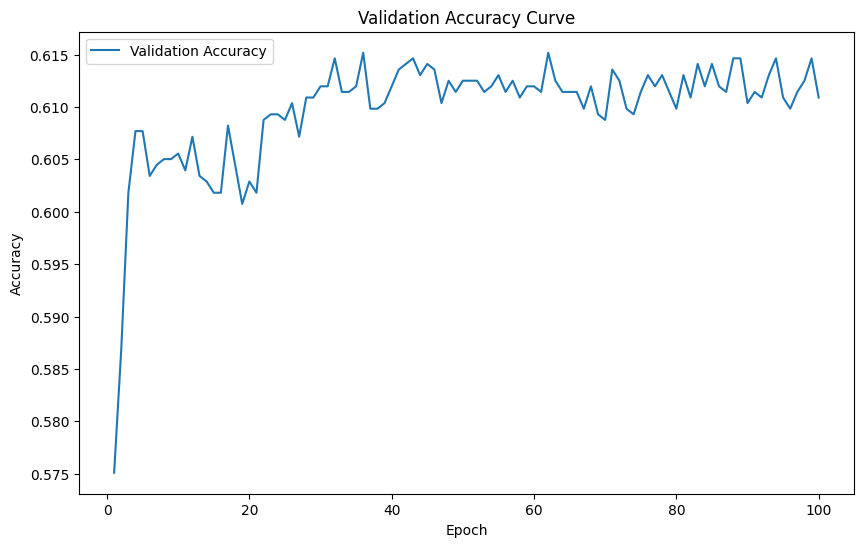

Accuracy on Test Set: 0.6109
F1 Score on Test Set: 0.5171
Total time taken : 46.16 seconds


In [58]:
import time
# Split the data into training and testing sets

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing to the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

le_target = LabelEncoder()
y_train_encoder = le_target.fit_transform(y_train)
y_test_encoder = le_target.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_preprocessed, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoder, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_preprocessed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoder, dtype=torch.long)


# Create DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a simple neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        # x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        return x


# Initialize the neural network model
input_size = X_train_preprocessed.shape[1]
hidden_size1=128
hidden_size2=128
output_size = len(y_train.unique())  # Number of unique classes

print(input_size, output_size)
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# Training the neural network
epochs = 100
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()


    # Compute training loss
    model.eval()
    with torch.no_grad():
        train_loss = criterion(model(X_train_tensor), y_train_tensor)
        train_losses.append(train_loss.item())
        
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())        
        
        _, y_pred = torch.max(val_outputs, 1)
        val_accuracy = accuracy_score(y_test_encoder, y_pred.numpy())
        val_accuracies.append(val_accuracy)

end_time = time.time()

# Plot learning curve with validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.title('Neural Network Learning Curve with Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


# Plot validation accuracy curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Evaluate on the test set
model.eval()
with torch.no_grad():
    _, y_pred = torch.max(model(X_test_tensor), 1)
    accuracy = accuracy_score(y_test_encoder, y_pred.numpy())
    f1 = f1_score(y_test_encoder, y_pred.numpy(), average='weighted')


print(f"Accuracy on Test Set: {accuracy:.4f}")
print(f"F1 Score on Test Set: {f1:.4f}")

total_time = end_time - start_time
print(f"Total time taken : {total_time:.2f} seconds")

In [54]:
%%time

# Evaluate on the test set
model.eval()
with torch.no_grad():
    _, y_pred = torch.max(model(X_test_tensor), 1)
    accuracy = accuracy_score(y_test_encoder, y_pred.numpy())
    f1 = f1_score(y_test_encoder, y_pred.numpy(), average='weighted')

print(f"Accuracy on Test Set: {accuracy:.4f}")
print(f"F1 Score on Test Set: {f1:.4f}")    

Accuracy on Test Set: 0.6077
F1 Score on Test Set: 0.5180
CPU times: total: 15.6 ms
Wall time: 7.05 ms


C:\Users\Abhishek.Agarwal\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


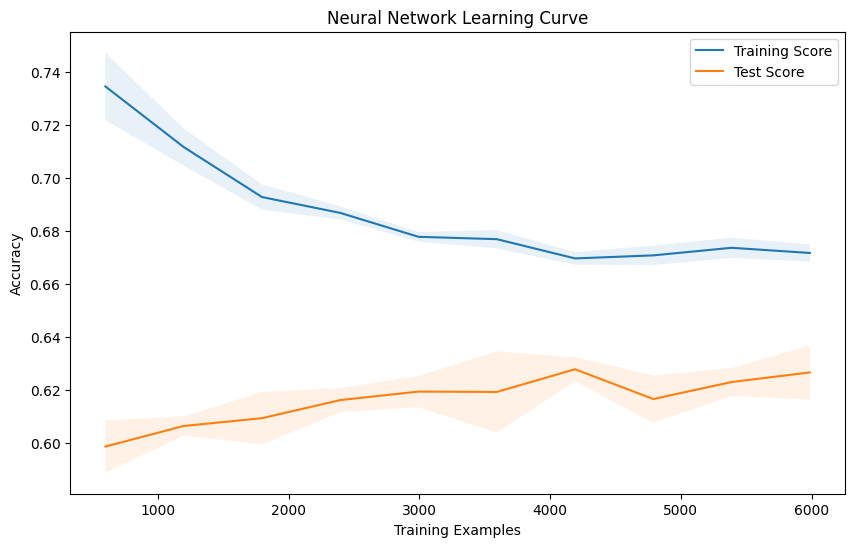

In [55]:
train_sizes = np.linspace(0.1, 1.0, 10)

clf = make_pipeline(StandardScaler(), MLPClassifier(hidden_layer_sizes=(256,), max_iter=1000, random_state=42))

# Define training sizes for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Plot the learning curve
plt.figure(figsize=(10, 6))
train_sizes, train_scores, test_scores = learning_curve(
    clf, X_train, y_train, cv=5, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_scores_mean, label='Training Score')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
plt.plot(train_sizes, test_scores_mean, label='Test Score')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)

plt.title('Neural Network Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [56]:
%%time

param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(64,), (128,), (256,)],
    'mlpclassifier__alpha': [0.0001, 0.001, 0.01],
}


# Create a PyTorch classifier using scikit-learn's make_pipeline
clf = make_pipeline(StandardScaler(), MLPClassifier(max_iter=1000, random_state=42))
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


# Fit the grid search to the data
grid_search.fit(X_train, y_train)


# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_


# Evaluate the best estimator on the test set
y_pred = best_estimator.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Review the GridSearch nominated optimal model parameters
grid_search.best_estimator_.get_params()

# Additional details from GridSearchCV
print("GridSearchCV Best Parameters:")
print(grid_search.best_params_)

# Print the results
print("Best Parameters:", best_params)
print("Test Set Accuracy:", accuracy)

C:\Users\Abhishek.Agarwal\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV Best Parameters:
{'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (64,)}
Best Parameters: {'mlpclassifier__alpha': 0.01, 'mlpclassifier__hidden_layer_sizes': (64,)}
Test Set Accuracy: 0.6082308925708177
CPU times: total: 1.5 s
Wall time: 1min 7s


C:\Users\Abhishek.Agarwal\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


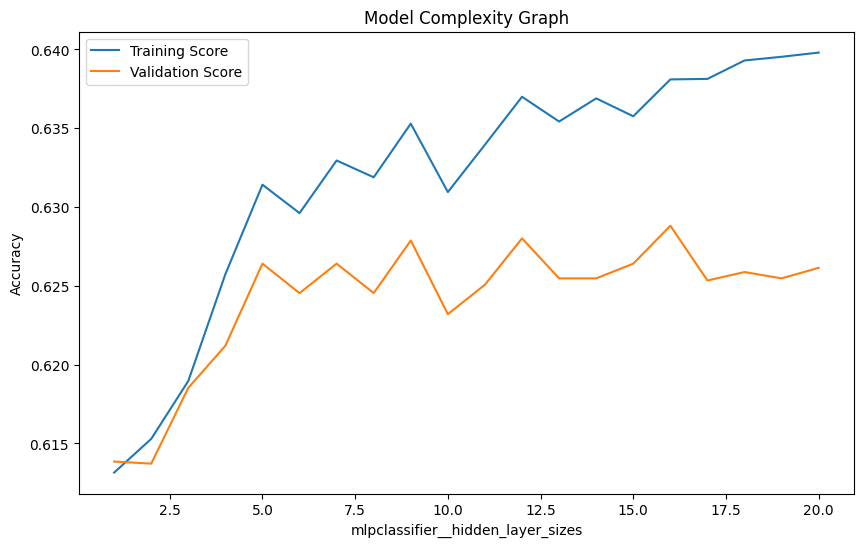

C:\Users\Abhishek.Agarwal\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


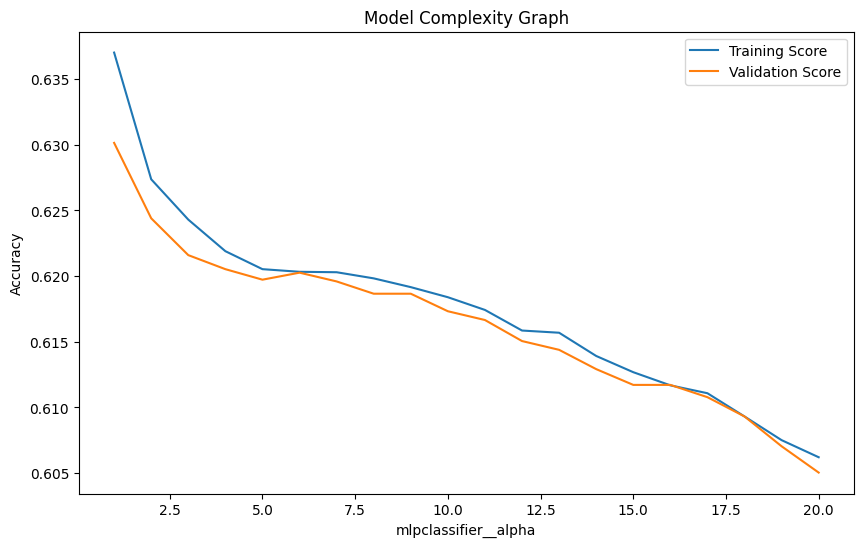

In [57]:
plot_validation_curve(clf,X_train, y_train,'mlpclassifier__hidden_layer_sizes', cv=5)
plot_validation_curve(clf,X_train, y_train,'mlpclassifier__alpha', cv=5)